In [ ]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
import matplotlib.animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

%matplotlib inline

env_cartpole = gym.make('CartPole-v1')

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
def animate_agent(env, agent, max_steps = 1000):
    obs = env.reset()
    frames = deque()
    frames.append(env.render(mode='rgb_array'))
    for _ in range(max_steps):
        out = agent(obs)
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, _ , done, _ = env.step(action)
        frames.append(env.render(mode='rgb_array'))
        if done:
            break

    return animate_frames(frames)

def animate_frames(frames):
    new_height = 2.2
    original_height = frames[0].shape[0]
    original_width = frames[0].shape[1]
    new_width = (new_height / original_height) * original_width
    fig = plt.figure(figsize=(new_width, new_height), dpi = 120)

    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    patch = ax.imshow(frames[0], aspect='auto', animated=True, interpolation='bilinear')
    animate = lambda i: patch.set_data(frames[i])

    ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(frames), interval = 50)

    plt.close()
    return HTML(ani.to_jshtml())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# def get_episode_trajectory(env, agent, max_steps=100000):
#     observation_list = []
#     reward_list = []
#     action_list = []
#     value_list = []
#     done_count = 0

#     done = False
#     obs = env.reset()
#     for _ in range(max_steps):
#         observation_list.append(obs)
#         out = agent(obs)
#         assert ("Action" in out), "The key 'Action' was missing from the agents output."
#         action = out["Action"]
#         obs, rew, done, truncated = env.step(action)
#         reward_list.append(rew)
#         action_list.append(action)
#         if "Value" in out:
#             value_list.append(out["Value"])

#         if done:
#             if not truncated:
#                 done_count += 1
#             break

#     ret = {
#         "Observations": observation_list,
#         "Actions": action_list,
#         "Rewards": np.array(reward_list, dtype=np.float32),
#         "Done Count": done_count
#     }
#     if len(value_list) > 0:
#         ret["Values"] = value_list

#     return ret

In [ ]:
def get_episode_trajectory(env, agent, max_steps=1000):
    observation_list = []
    reward_list = []
    action_list = []
    value_list = []

    done = False
    obs = env.reset()
    for _ in range(max_steps):
        observation_list.append(obs)
        out = agent(obs)
        assert ("Action" in out), "The key 'Action' was missing from the agents output."
        action = out["Action"]
        obs, rew, done, _, = env.step(action)
        reward_list.append(rew)
        action_list.append(action)
        if "Value" in out:
            value_list.append(out["Value"])

        if done:
            break

    ret = {
        "Observations": observation_list,
        "Actions": action_list,
        "Rewards": np.array(reward_list, dtype=np.float32)
    }
    if len(value_list) > 0:
        ret["Values"] = value_list

    return ret

In [ ]:
def reward_to_go(rewards):
    return np.flip(np.cumsum(np.flip(rewards)))

In [ ]:
def reward_to_go_normalized(rewards):
    adv = reward_to_go(rewards)
    eps = 0.00001
    return (adv - adv.mean()) / (adv.std() + eps)

In [ ]:
class AgentMLPTF(Model):
  def __init__(self):
    super(AgentMLPTF, self).__init__()
    self.d1 = Dense(15, activation='tanh')
    self.d2 = Dense(15, activation='tanh')
    self.d3 = Dense(2)

  def call(self, x):
    # 1. Define Policy
    batch = True
    if x.ndim == 1:
        batch = False
        x = np.expand_dims(x, axis=0)
    x = self.d1(x)
    x = self.d2(x)
    action_logits = self.d3(x)

    # 2. Sample policy to get action
    action = tf.random.categorical(action_logits, 1)
    action = action.numpy().flatten()
    if not batch:
        action = np.ndarray.item(action)

    return {"Action":action, "LogProbability":action_logits}

In [ ]:
def loss_pg(actions, logits, weights):
    actions = tf.cast(actions, dtype=tf.int32)  # Ensure actions are integers
    action_masks = tf.one_hot(actions, 2, dtype=tf.float64)
    logits = tf.cast(logits, dtype=tf.float64)  # Ensure logits are double tensors
    log_probs = tf.reduce_sum(action_masks * tf.nn.log_softmax(logits), axis=1)
    return -tf.reduce_mean(weights * log_probs)

In [ ]:
# def train_policy_grad(env, agent, num_epochs=250, max_episode_steps=100000):
#     optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
#     log_reward = 0
#     total_position = 0
#     total_done_count = 0
#     log_reward_list = []
#     avg_pos_list = []
#     logging_period = 20

#     for epoch in range(num_epochs):
#         # get the training data
#         traj = get_episode_trajectory(env, agent, max_steps=max_episode_steps)
#         obs = np.stack(traj["Observations"])
#         rew = traj["Rewards"]
#         actions = traj["Actions"]
#         done_count = traj["Done Count"]
#         position = obs[0][0]


#         # compute 'reward-to-go'
#         rew_2_go = reward_to_go_normalized(rew)

#         # compute gradients + update weights
#         with tf.GradientTape() as tape:
#             logits = agent(obs)["LogProbability"]
#             loss = loss_pg(actions, logits, rew_2_go)

#         gradients = tape.gradient(loss, agent.trainable_variables)
#         optimizer.apply_gradients(zip(gradients, agent.trainable_variables))

#         # log the reward
#         log_reward += np.sum(rew)
#         total_position += np.abs(position)
#         total_done_count += done_count
#         if (epoch % logging_period) == 0:
#             template = 'Training Epoch {}, Averaged Return: {}, Averaged Position: {}, Failed Count: {}'
#             print(template.format(epoch, log_reward / logging_period, total_position / logging_period, total_done_count))
#             log_reward_list.append(log_reward / logging_period)
#             avg_pos_list.append(total_position / logging_period)
#             log_reward = 0

#     return (range(0, num_epochs, logging_period), log_reward_list, avg_pos_list, done_count)

In [ ]:
def get_success_rate(env, agent, num_episodes=100, max_steps=200):
    success_count = 0
    for _ in range(num_episodes):
        obs = env.reset()
        terminated = False
        for _ in range(max_steps):
            action = agent(obs)["Action"]
            obs, reward, terminated, truncated = env.step(action)
            # print("Results: ")
            # print(obs, reward, terminated, truncated)
            #if terminated:
            if terminated:
              if truncated["TimeLimit.truncated"] == False:
                success_count += 1  # Pole balanced successfully for max_steps
              break
    return success_count / num_episodes

In [ ]:
def train_policy_grad(env, agent, num_epochs=250, max_episode_steps=1000):
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-2)
    log_reward = 0
    log_reward_list = []
    success_rate_list = []  # Store success rate at each logging period
    logging_period = 20

    for epoch in range(num_epochs):
        # get the training data
        traj = get_episode_trajectory(env, agent, max_steps=max_episode_steps)
        obs = np.stack(traj["Observations"])
        rew = traj["Rewards"]
        actions = traj["Actions"]

        # compute 'reward-to-go'
        rew_2_go = reward_to_go_normalized(rew)

        # compute gradients + update weights
        with tf.GradientTape() as tape:
            logits = agent(obs)["LogProbability"]
            loss = loss_pg(actions, logits, rew_2_go)

        gradients = tape.gradient(loss, agent.trainable_variables)
        optimizer.apply_gradients(zip(gradients, agent.trainable_variables))

        # log the reward
        log_reward += np.sum(rew)
        if (epoch % logging_period) == 0:
            template = 'Training Epoch {}, Averaged Return: {}, Success Rate: {}'
            success_rate = 1 - get_success_rate(env, agent)
            print(template.format(epoch, log_reward / logging_period, success_rate))
            log_reward_list.append(log_reward / logging_period)
            success_rate_list.append(success_rate)
            log_reward = 0

    return (range(0, num_epochs, logging_period), log_reward_list, success_rate_list)

In [ ]:
agent_mlp_tf = AgentMLPTF()
(episodes, rewards, success_rates) = train_policy_grad(env_cartpole, agent_mlp_tf)

Training Epoch 0, Averaged Return: 0.9, Success Rate: 0.0
Training Epoch 20, Averaged Return: 22.8, Success Rate: 0.0
Training Epoch 40, Averaged Return: 90.5, Success Rate: 0.040000000000000036
Training Epoch 60, Averaged Return: 188.4, Success Rate: 0.0
Training Epoch 80, Averaged Return: 245.35, Success Rate: 1.0
Training Epoch 100, Averaged Return: 500.0, Success Rate: 1.0
Training Epoch 120, Averaged Return: 500.0, Success Rate: 0.9299999999999999
Training Epoch 140, Averaged Return: 433.3, Success Rate: 0.98
Training Epoch 160, Averaged Return: 477.0, Success Rate: 1.0
Training Epoch 180, Averaged Return: 369.0, Success Rate: 0.8
Training Epoch 200, Averaged Return: 272.15, Success Rate: 0.39
Training Epoch 220, Averaged Return: 444.55, Success Rate: 1.0
Training Epoch 240, Averaged Return: 500.0, Success Rate: 1.0


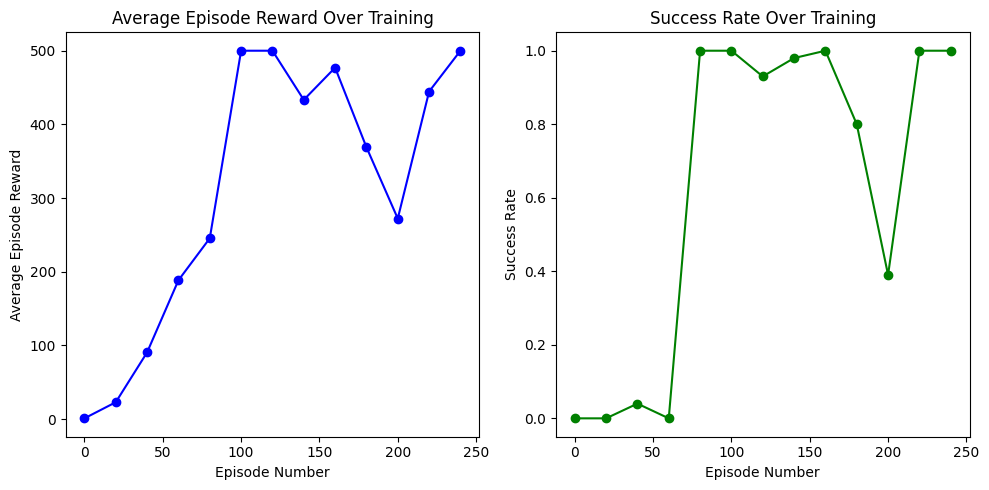

In [ ]:
# Plotting both average episode reward and success rate
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(episodes, rewards, 'bo-')
plt.xlabel('Episode Number')
plt.ylabel('Average Episode Reward')
plt.title('Average Episode Reward Over Training')

plt.subplot(1, 2, 2)
plt.plot(episodes, success_rates, 'go-')
plt.xlabel('Episode Number')
plt.ylabel('Success Rate')
plt.title('Success Rate Over Training')

plt.tight_layout()
plt.show()